In [617]:
%reset -f

In [618]:
import pandas as pd
import numpy as np
arms_data = pd.read_csv('Arms.csv')
heads_data = pd.read_csv('Heads.csv')
torsos_data = pd.read_csv('Torsos.csv')
legs_data = pd.read_csv('Legs.csv')

In [619]:
def get_playstyle_list(dataframe):
        return dataframe["Playstyle"].drop_duplicates().to_list()

def progressively_order(dataframe: pd.DataFrame):
        # Assign a check number based on the progressive order of each item
        playstyle_list = get_playstyle_list(dataframe)
        if not 'Check Number' in dataframe:
                dataframe.insert(1, 'Check Number', '')
        dataframe.sort_values(by=['Playstyle', 'Level'], inplace=True)
        for playstyle in playstyle_list:
                i = 1
                for index, row in dataframe[dataframe['Playstyle'] == playstyle].iterrows():
                        dataframe.at[index, 'Check Number'] = i
                        i += 1
        return dataframe

arms_data = progressively_order(arms_data)
heads_data = progressively_order(heads_data)
torsos_data = progressively_order(torsos_data)
legs_data = progressively_order(legs_data)

In [620]:
# Removes items that are obtained in a certain way.
def pop_if_obtained_via(dataframe: pd.DataFrame, methods: list):
        # Create a deep copy so the original dataframe is not mutable
        dataframe = dataframe.copy()

        # Safety check for a list (python moment)
        if isinstance(methods, str):
                methods = [methods]

        for method in methods:
                # Remove anything in Also
                for index, row in dataframe[dataframe['Also Obtained Via'] == method].iterrows():
                        dataframe.at[index, 'Also Obtained Via'] = np.nan

                # If the first method isn't valid, copy over the second one to it
                for index, row in dataframe[dataframe['Obtained Via'] == method].iterrows():
                        dataframe.at[index, 'Obtained Via'] = dataframe.at[index, 'Also Obtained Via']
                        dataframe.at[index, 'Also Obtained Via'] = np.nan
                        # If it ends up null, then just remove it entirely
                        if pd.isnull(dataframe.at[index, 'Obtained Via']):
                                dataframe = dataframe.drop(index)

        dataframe = dataframe.reset_index(drop=True)
        dataframe = progressively_order(dataframe)
        return dataframe

# pop_if_obtained_via(df, ('Shop'))

In [621]:
import itertools

# Get all combinations of obtained methods
OBTAINED_METHODS = ['Trade', 'Shop', 'Chest', 'Quest']
# Empty combination represents the inverse of all toggles
obtained_combinations = [ [()] ]
for n in range(1, 5):
        obtained_combinations.append((list(itertools.combinations(OBTAINED_METHODS, n))))

In [622]:
#####
#
# Code taken from https://www.w3resource.com/python-exercises/string/python-data-type-string-exercise-96.php
#
#####

# Import the 'sub' function from the 're' module for regular expression substitution
from re import sub

# Define a function to convert a string to camel case
def camel_case(s):
    # Use regular expression substitution to replace underscores and hyphens with spaces,
    # then title case the string (capitalize the first letter of each word), and remove spaces
    s = sub(r"(_|-)+", " ", s).title().replace(" ", "")

    # Join the string, ensuring the first letter is lowercase
    return ''.join([s[0].lower(), s[1:]])


In [625]:
def change_series_playstyle(df: pd.DataFrame, playstyle_from: str, playstyle_to: str):
        for index, row in df[df['Playstyle'] == playstyle_from].iterrows():
                df.at[index, 'Playstyle'] = playstyle_to
        df = progressively_order(df)

def merge_series_playstyles(df: pd.DataFrame, to_merge: list, merge_into: str, debug=False):
        # Sanity check
        if isinstance(to_merge, str): to_merge = [to_merge]
        for series in to_merge:
                if debug: print(to_merge)
                change_series_playstyle(df, series, merge_into)

def randomly_distribute_playstyle_into(df: pd.DataFrame, playstyle_from: str, merge_into: list, debug=False):
        # Sanity check
        if isinstance(merge_into, str): merge_into = [merge_into]
        df = progressively_order(df)
        i = 0
        for index, row in df[df['Playstyle'] == playstyle_from].iterrows():
                if debug: print(f"{ df.at[index, 'Name'] }, { df.at[index, 'Level'] }, { df.at[index, 'Playstyle'] } -> { merge_into[i] }")
                df.at[index, 'Playstyle'] = merge_into[i]
                i += 1
                if (i >= len(merge_into)): i = 0
        if debug: print(df)


# Make manual adjustments to graphs' series according to their specific needs.
def adjust_graph_data(graph_data: pd.DataFrame, title: str, combo_inverted: list):
        if title == 'Heads':
                match combo_inverted:
                        case ['Trade', 'Shop', 'Chest', 'Quest']:
                                change_series_playstyle(graph_data, 'Botany', 'All-Purpose')
                        case ['Shop', 'Chest', 'Quest']:
                                merge_series_playstyles(graph_data, ['Defensive', 'Botany'], 'Special')
                        case ['Trade', 'Chest', 'Quest']:
                                change_series_playstyle(graph_data, 'Botany', 'All-Purpose')
                        case ['Trade', 'Shop', 'Quest']:
                                change_series_playstyle(graph_data, 'Botany', 'All-Purpose')
                        case ['Chest', 'Quest']:
                                merge_series_playstyles(graph_data, ['All-Purpose', 'Defensive', 'Botany'], '')
                        case ['Shop', 'Quest']:
                                merge_series_playstyles(graph_data, ['All-Purpose', 'Defensive', 'Botany'], '')
                        case ['Shop', 'Chest']:
                                merge_series_playstyles(graph_data, ['All-Purpose', 'Defensive', 'Botany'], '')
                        case ['Trade', 'Quest']:
                                change_series_playstyle(graph_data, 'Botany', 'All-Purpose')
                                randomly_distribute_playstyle_into(graph_data, 'All-Purpose', ['Offensive', 'Defensive'])
                        case ['Trade', 'Chest']:
                                randomly_distribute_playstyle_into(graph_data, 'All-Purpose', ['Offensive', 'Defensive'])
                        case ['Quest']:
                                merge_series_playstyles(graph_data, ['All-Purpose', 'Defensive', 'Botany'], '')
                        case ['Chest']:
                                merge_series_playstyles(graph_data, ['All-Purpose', 'Defensive'], '')
                        case ['Shop']:
                                merge_series_playstyles(graph_data, ['All-Purpose', 'Defensive'], '')
                        case ['Trade']:
                                change_series_playstyle(graph_data, 'All-Purpose', 'Defensive')
                        case []:
                                pass

        elif title == 'Arms':
                match combo_inverted:
                        case ['Shop', 'Chest', 'Quest']:
                                merge_series_playstyles(graph_data, ['Defensive', 'Ranged', 'Melee'], 'Class-Based')
                        case ['Trade', 'Chest', 'Quest']:
                                change_series_playstyle(graph_data, 'All-Purpose', 'Special')
                        case ['Chest', 'Quest']:
                                change_series_playstyle(graph_data, 'All-Purpose', 'Special')
                                merge_series_playstyles(graph_data, ['Defensive', 'Ranged', 'Melee'], 'Class-Based')
                        case ['Shop', 'Quest']:
                                merge_series_playstyles(graph_data, ['Special', 'Ranged', 'Defensive', 'All-Purpose'], '')
                        case ['Shop', 'Chest']:
                                merge_series_playstyles(graph_data, ['Defensive', 'Ranged', 'Melee'], 'Class-Based')
                        case ['Trade', 'Quest']:
                                change_series_playstyle(graph_data, 'All-Purpose', 'Special')
                        case ['Trade', 'Chest']:
                                change_series_playstyle(graph_data, 'All-Purpose', 'Special')
                        case ['Quest']:
                                merge_series_playstyles(graph_data, ['All-Purpose', 'Defensive', 'Ranged', 'Special'], '')
                        case ['Chest']:
                                merge_series_playstyles(graph_data, ['Defensive', 'Ranged', 'Melee'], 'Class-Based')
                        case ['Trade']:
                                change_series_playstyle(graph_data, 'All-Purpose', 'Special')

        elif title == 'Torsos':
                match combo_inverted:
                        case ['Shop', 'Chest', 'Quest']:
                                merge_series_playstyles(graph_data, ['All-Purpose', 'Defensive', 'Mixed', 'Offensive'], '')
                        case ['Trade', 'Chest', 'Quest']:
                                change_series_playstyle(graph_data, 'All-Purpose', 'Mixed')
                        case ['Chest', 'Quest']:
                                merge_series_playstyles(graph_data, ['All-Purpose', 'Defensive', 'Mixed', 'Offensive'], '')
                        case ['Shop', 'Quest']:
                                merge_series_playstyles(graph_data, ['All-Purpose', 'Defensive', 'Mixed', 'Offensive'], '')
                        case ['Shop', 'Chest']:
                                merge_series_playstyles(graph_data, ['All-Purpose', 'Defensive', 'Mixed', 'Offensive'], '')
                        case ['Trade', 'Quest']:
                                change_series_playstyle(graph_data, 'All-Purpose', 'Mixed')
                        case ['Trade', 'Chest']:
                                change_series_playstyle(graph_data, 'All-Purpose', 'Mixed')
                                merge_series_playstyles(graph_data, ['Defensive', 'Offensive'], 'Class-Based')
                        case ['Quest']:
                                change_series_playstyle(graph_data, 'All-Purpose', '')
                        case ['Chest']:
                                merge_series_playstyles(graph_data, ['All-Purpose', 'Defensive', 'Mixed', 'Offensive'], '')
                        case ['Shop']:
                                merge_series_playstyles(graph_data, ['All-Purpose', 'Offensive'], '')
                        case ['Trade']:
                                change_series_playstyle(graph_data, 'All-Purpose', 'Mixed')

        elif title == 'Legs':
                match combo_inverted:
                        case ['Shop', 'Chest', 'Quest']:
                                merge_series_playstyles(graph_data, ['Offensive', 'Defensive', 'All-Purpose'], '')
                        case ['Trade', 'Chest', 'Quest']:
                                change_series_playstyle(graph_data, 'All-Purpose', 'Offensive')
                        case ['Chest', 'Quest']:
                                merge_series_playstyles(graph_data, ['Offensive', 'Defensive', 'All-Purpose'], '')
                        case ['Shop', 'Chest']:
                                merge_series_playstyles(graph_data, ['Offensive', 'Defensive', 'All-Purpose'], '')
                        case ['Shop', 'Quest']:
                                merge_series_playstyles(graph_data, ['Offensive', 'Defensive', 'All-Purpose'], '')
                        case ['Trade', 'Quest']:
                                change_series_playstyle(graph_data, 'All-Purpose', 'Offensive')
                        case ['Trade', 'Chest']:
                                change_series_playstyle(graph_data, 'All-Purpose', 'Offensive')
                        case ['Quest']:
                                merge_series_playstyles(graph_data, ['Offensive', 'Defensive', 'All-Purpose'], '')
                        case ['Chest']:
                                merge_series_playstyles(graph_data, ['All-Purpose', 'Defensive'], '')
                        case ['Shop']:
                                merge_series_playstyles(graph_data, ['Offensive', 'Defensive', 'All-Purpose'], '')
                        case ['Trade']:
                                change_series_playstyle(graph_data, 'All-Purpose', 'Offensive')

def get_id_from_series_id(series_id: str):
        match series_id:
                case "headsAllPurpose": return 60
                case "headsDefensive": return 61
                case "headsOffensive": return 62
                case "headsSpecial": return 63
                case "heads": return 64

                case "armsAllPurpose": return 70
                case "armsDefensive": return 71
                case "armsMelee": return 72
                case "armsRanged": return 73
                case "armsSpecial": return 74
                case "armsClassBased": return 75
                case "arms": return 76

                case "torsosAllPurpose": return 80
                case "torsosDefensive": return 81
                case "torsosMixed": return 82
                case "torsosOffensive": return 83
                case "torsos": return 84
                case "torsosClassBased": return 85

                case "legsAllPurpose": return 90
                case "legsDefensive": return 91
                case "legsOffensive": return 92
                case "legs": return 93

                case _:
                        print(f"ID not found: {series_id}")
                        return -1

      Name Check Number  Level   Type  Playstyle  \
12  Daikon            1     13  MAXHP  Defensive   

                         Statistics Obtained Via Also Obtained Via Series  \
12  MAXHP +69 ATK +11 HP Regen +15%        Trade             Chest  MAXHP   

   Sub Trait  Base Count Is Renewable Is Ingredient Notes  Unnamed: 13  \
12       NaN           2    Renewable           NaN   NaN          NaN   

   Excluded Name Level.1 Type.1 Reason  
12           NaN     NaN    NaN    NaN  
     Name Check Number  Level   Type  Playstyle  \
8  Daikon            1     13  MAXHP  Defensive   

                        Statistics Obtained Via Also Obtained Via Series  \
8  MAXHP +69 ATK +11 HP Regen +15%        Chest               NaN  MAXHP   

  Sub Trait  Base Count Is Renewable Is Ingredient Notes  Unnamed: 13  \
8       NaN           1    Renewable           NaN   NaN          NaN   

  Excluded Name Level.1 Type.1 Reason  
8           NaN     NaN    NaN    NaN  
     Name Check Number  Le

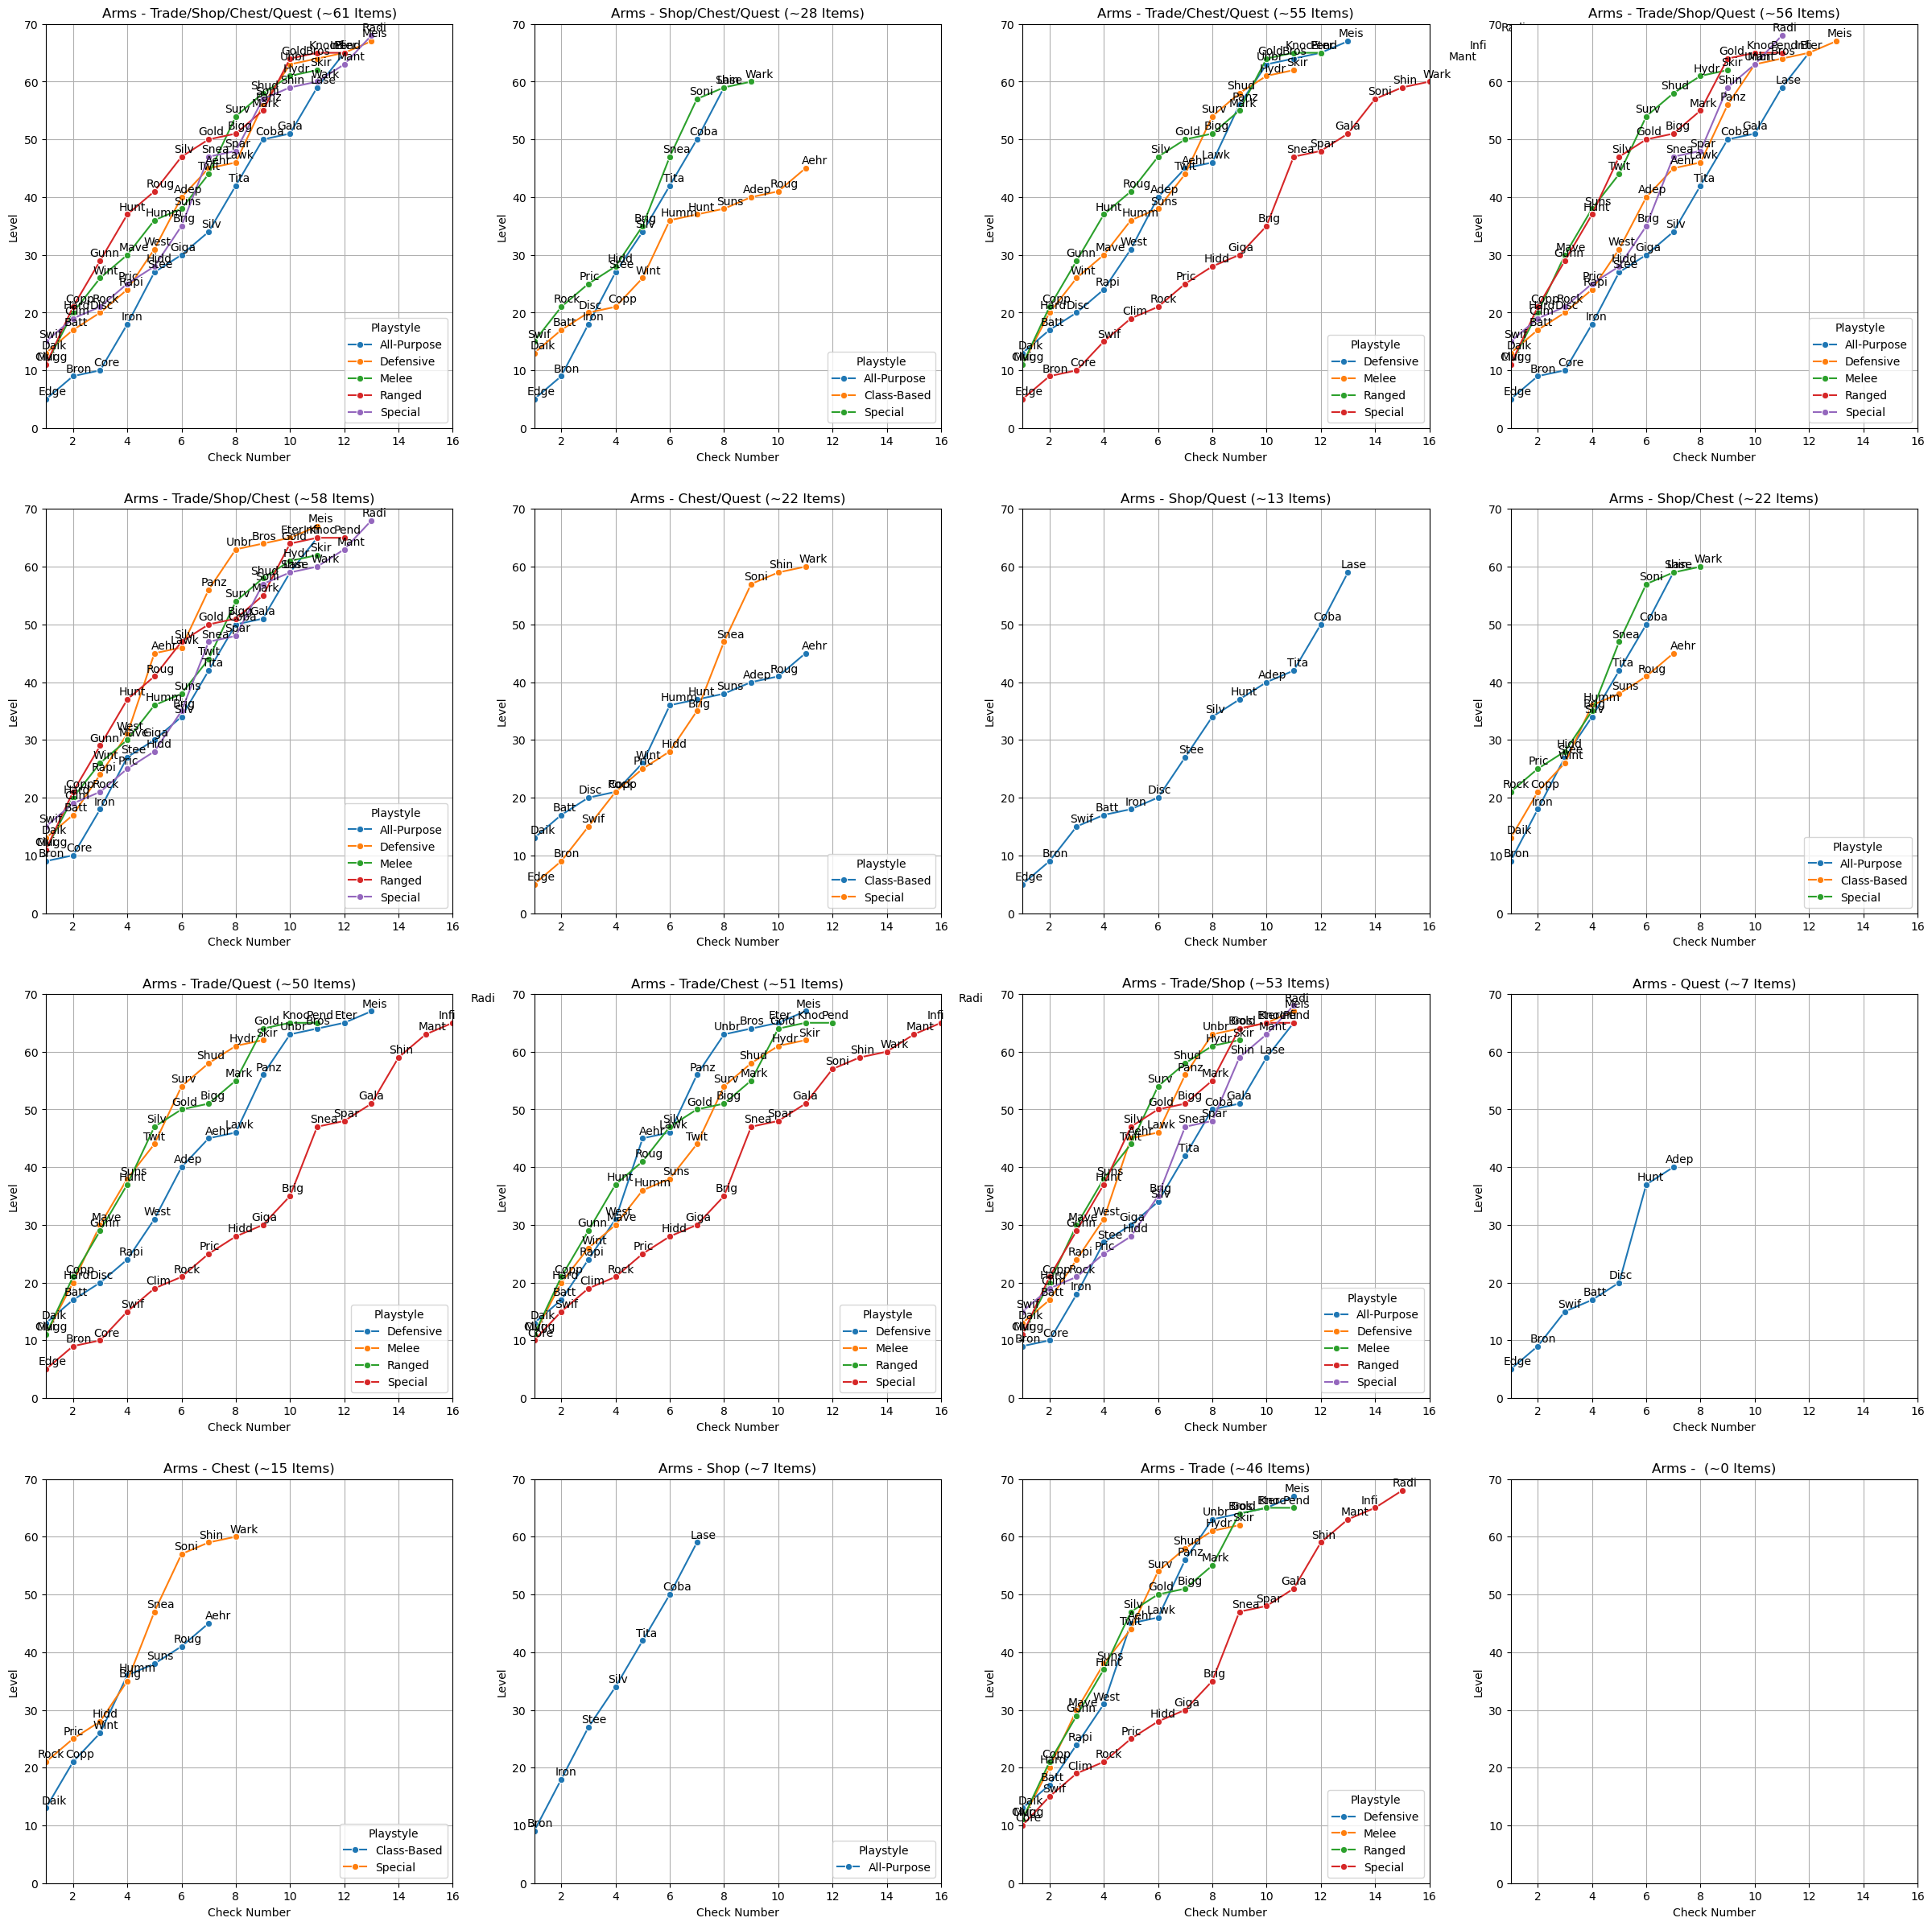

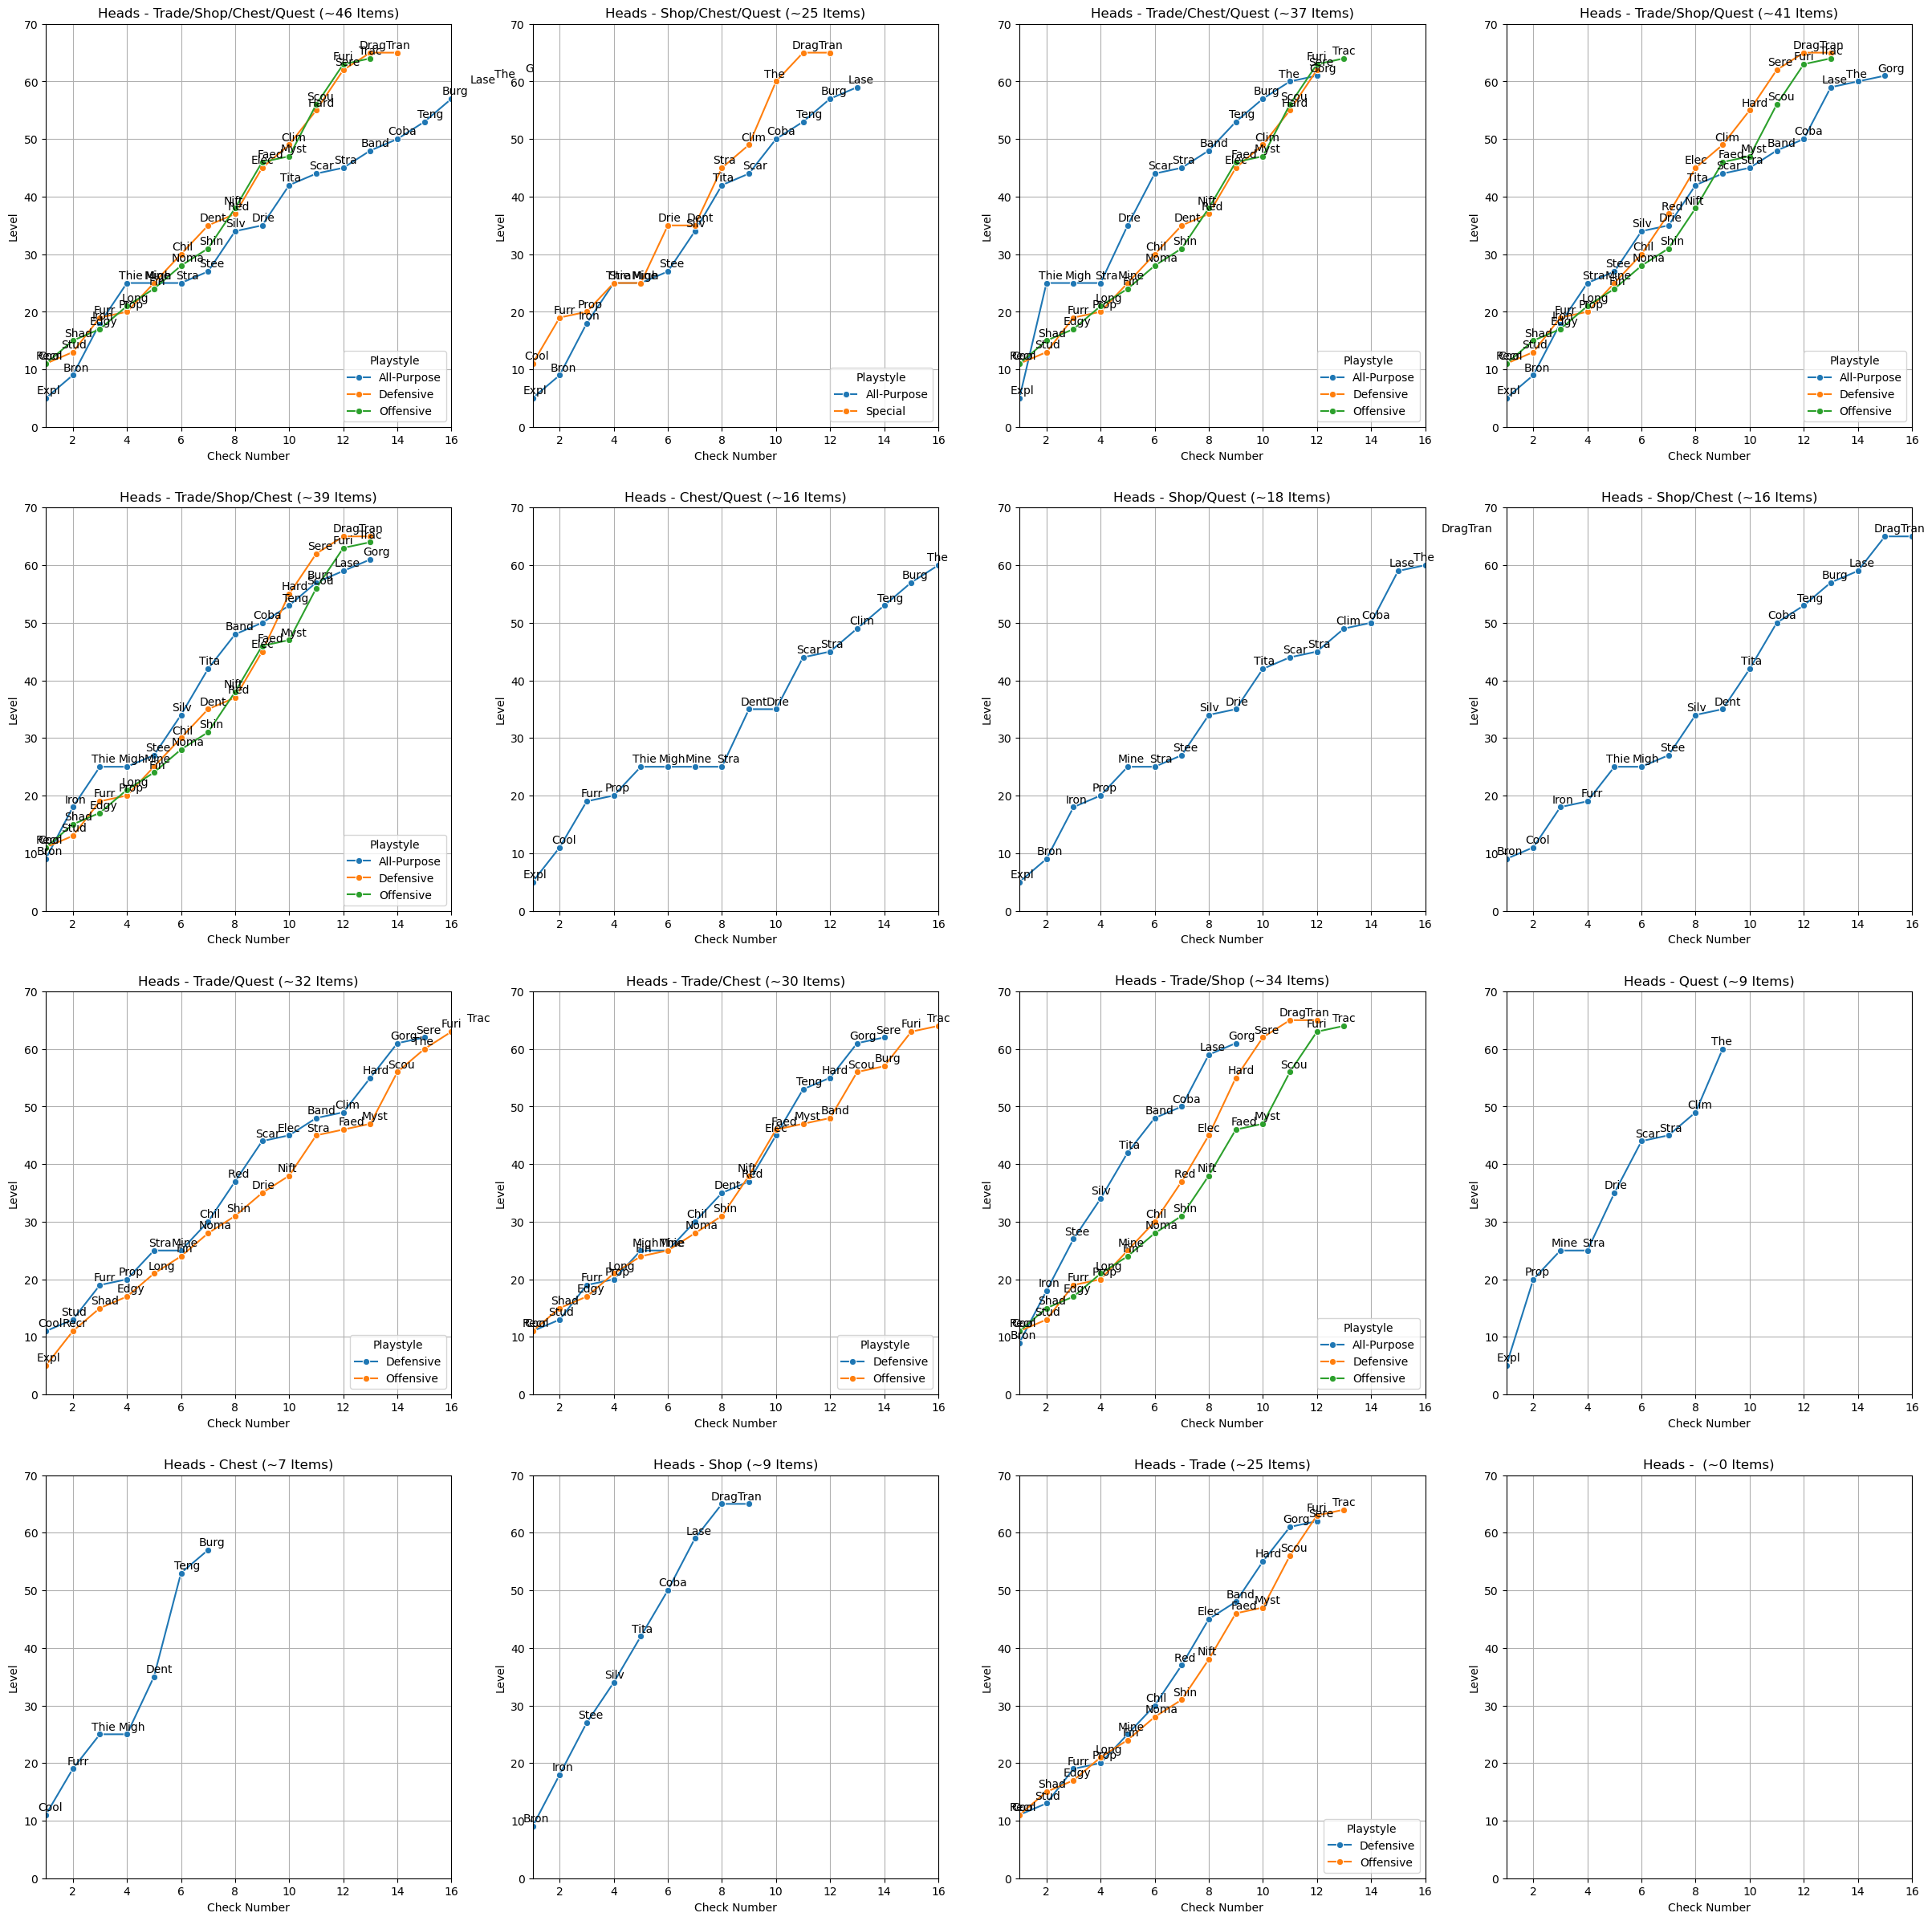

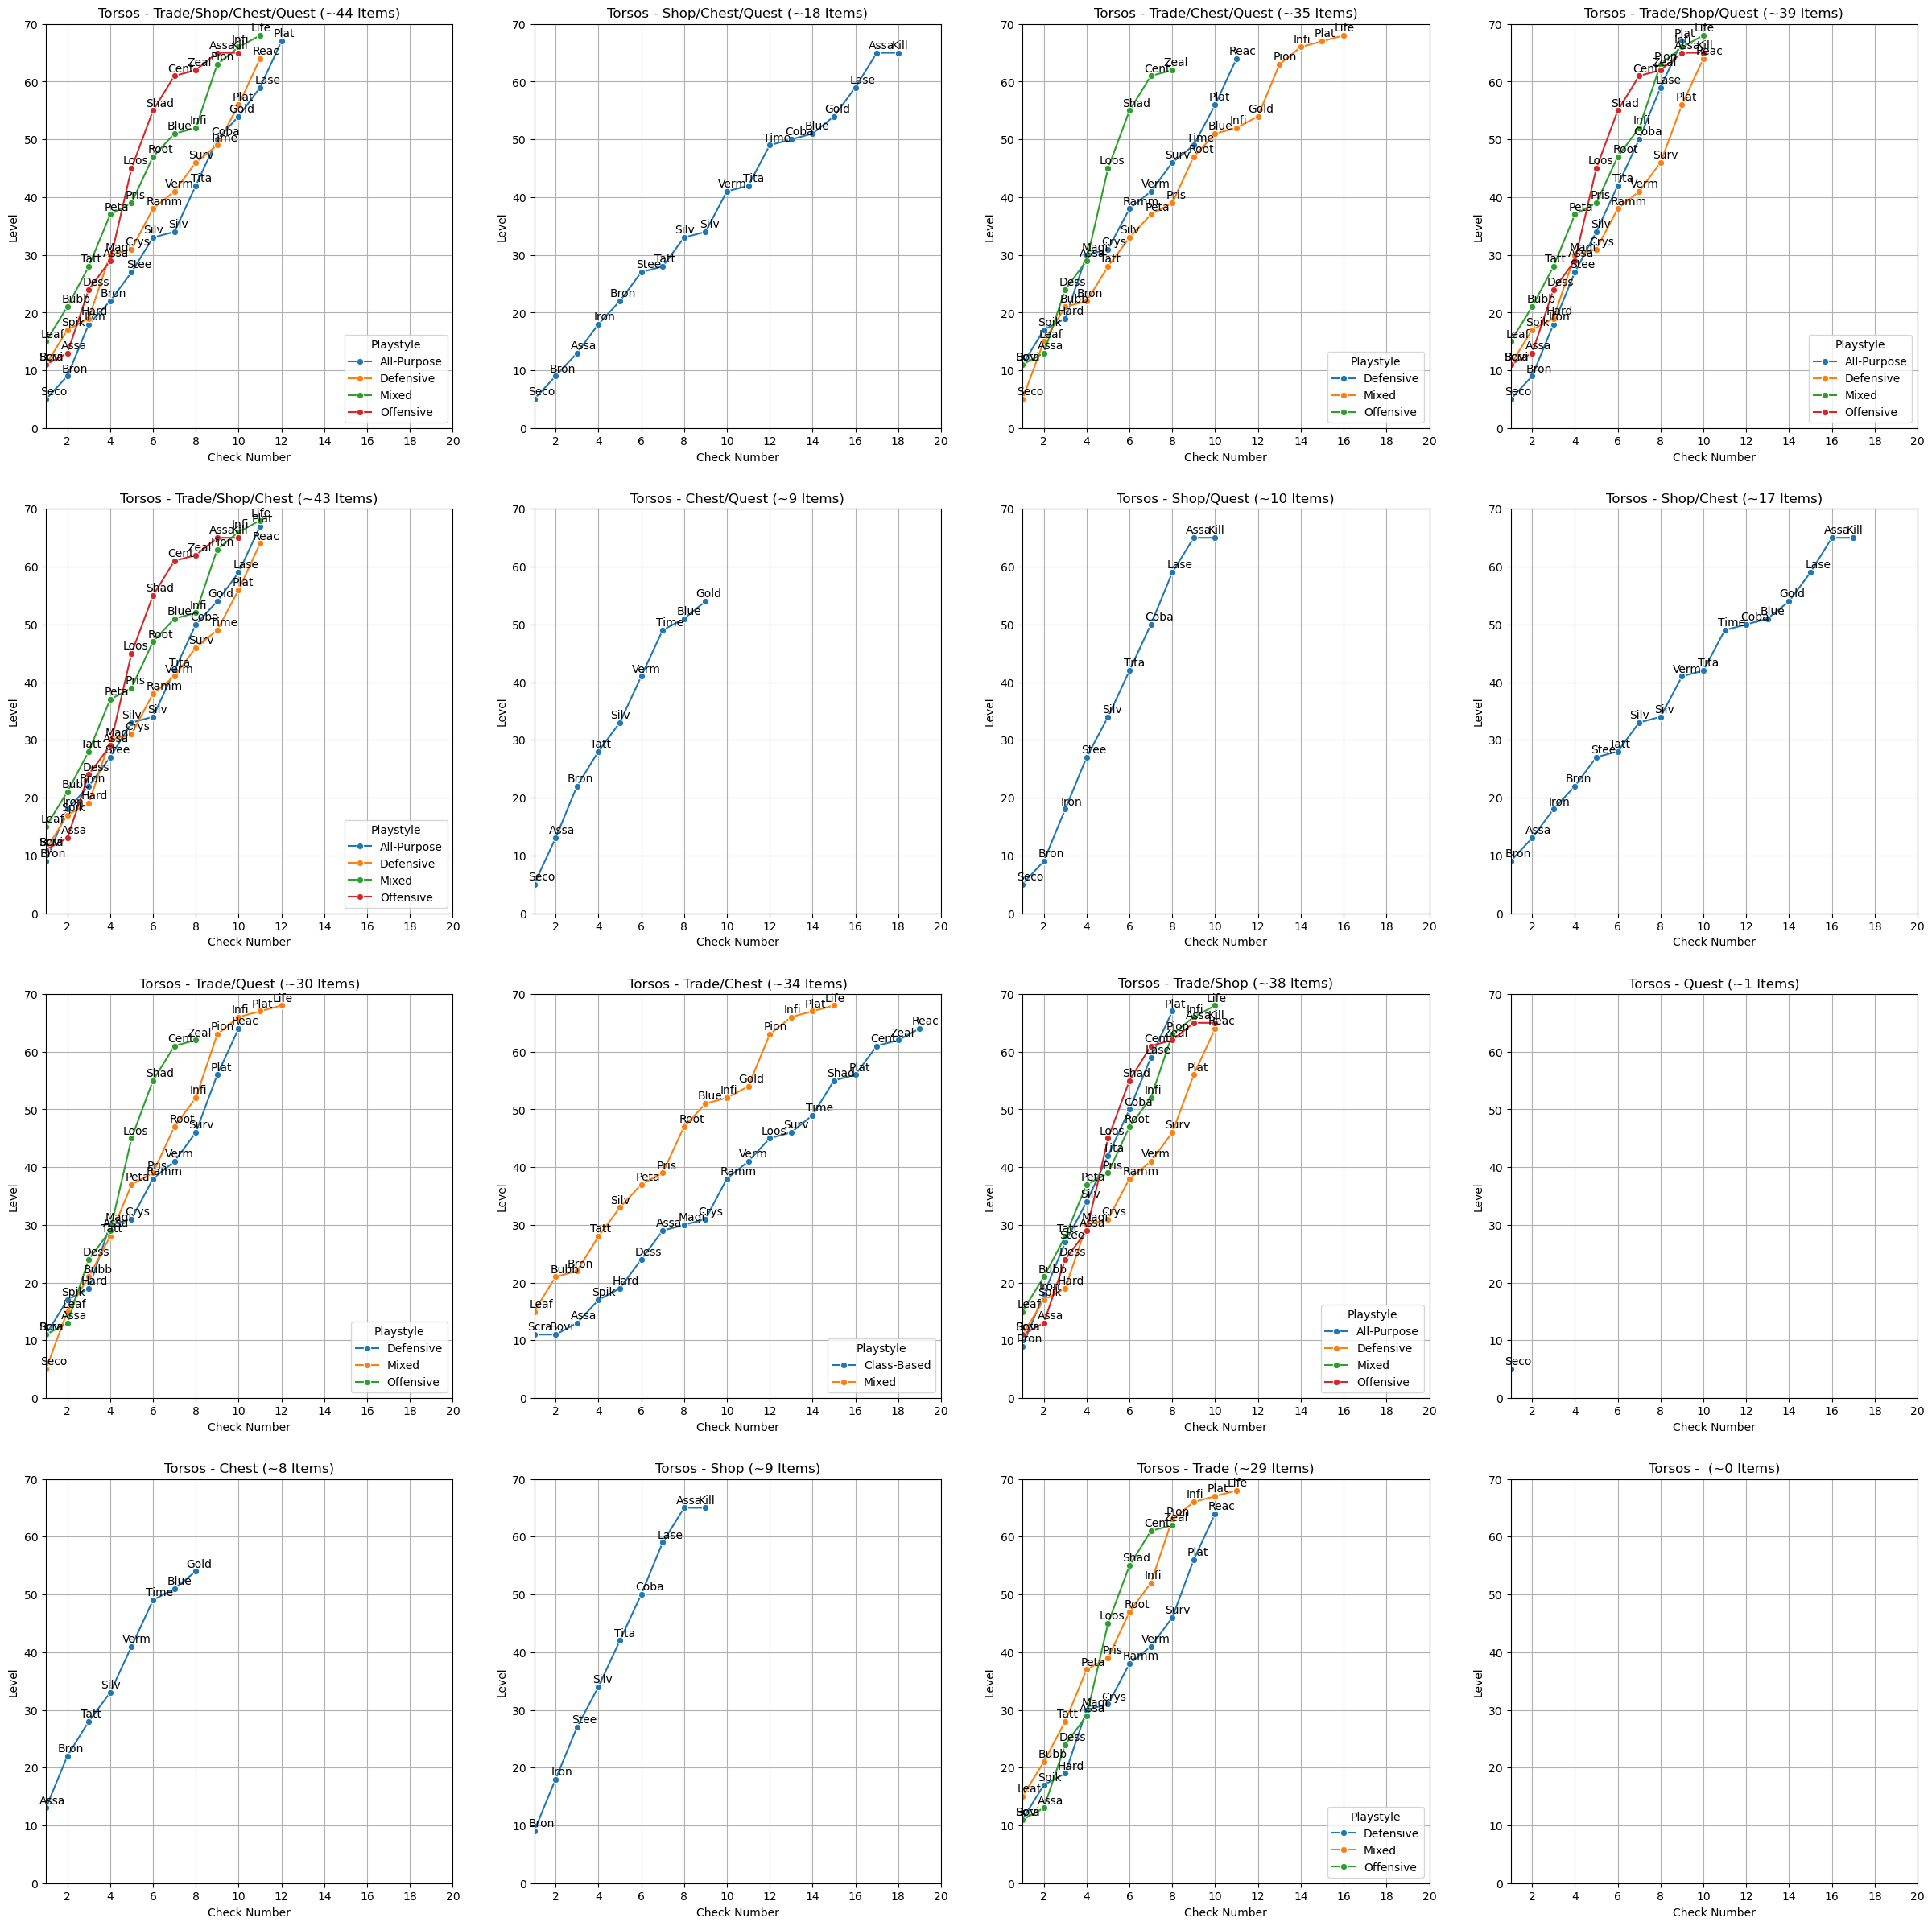

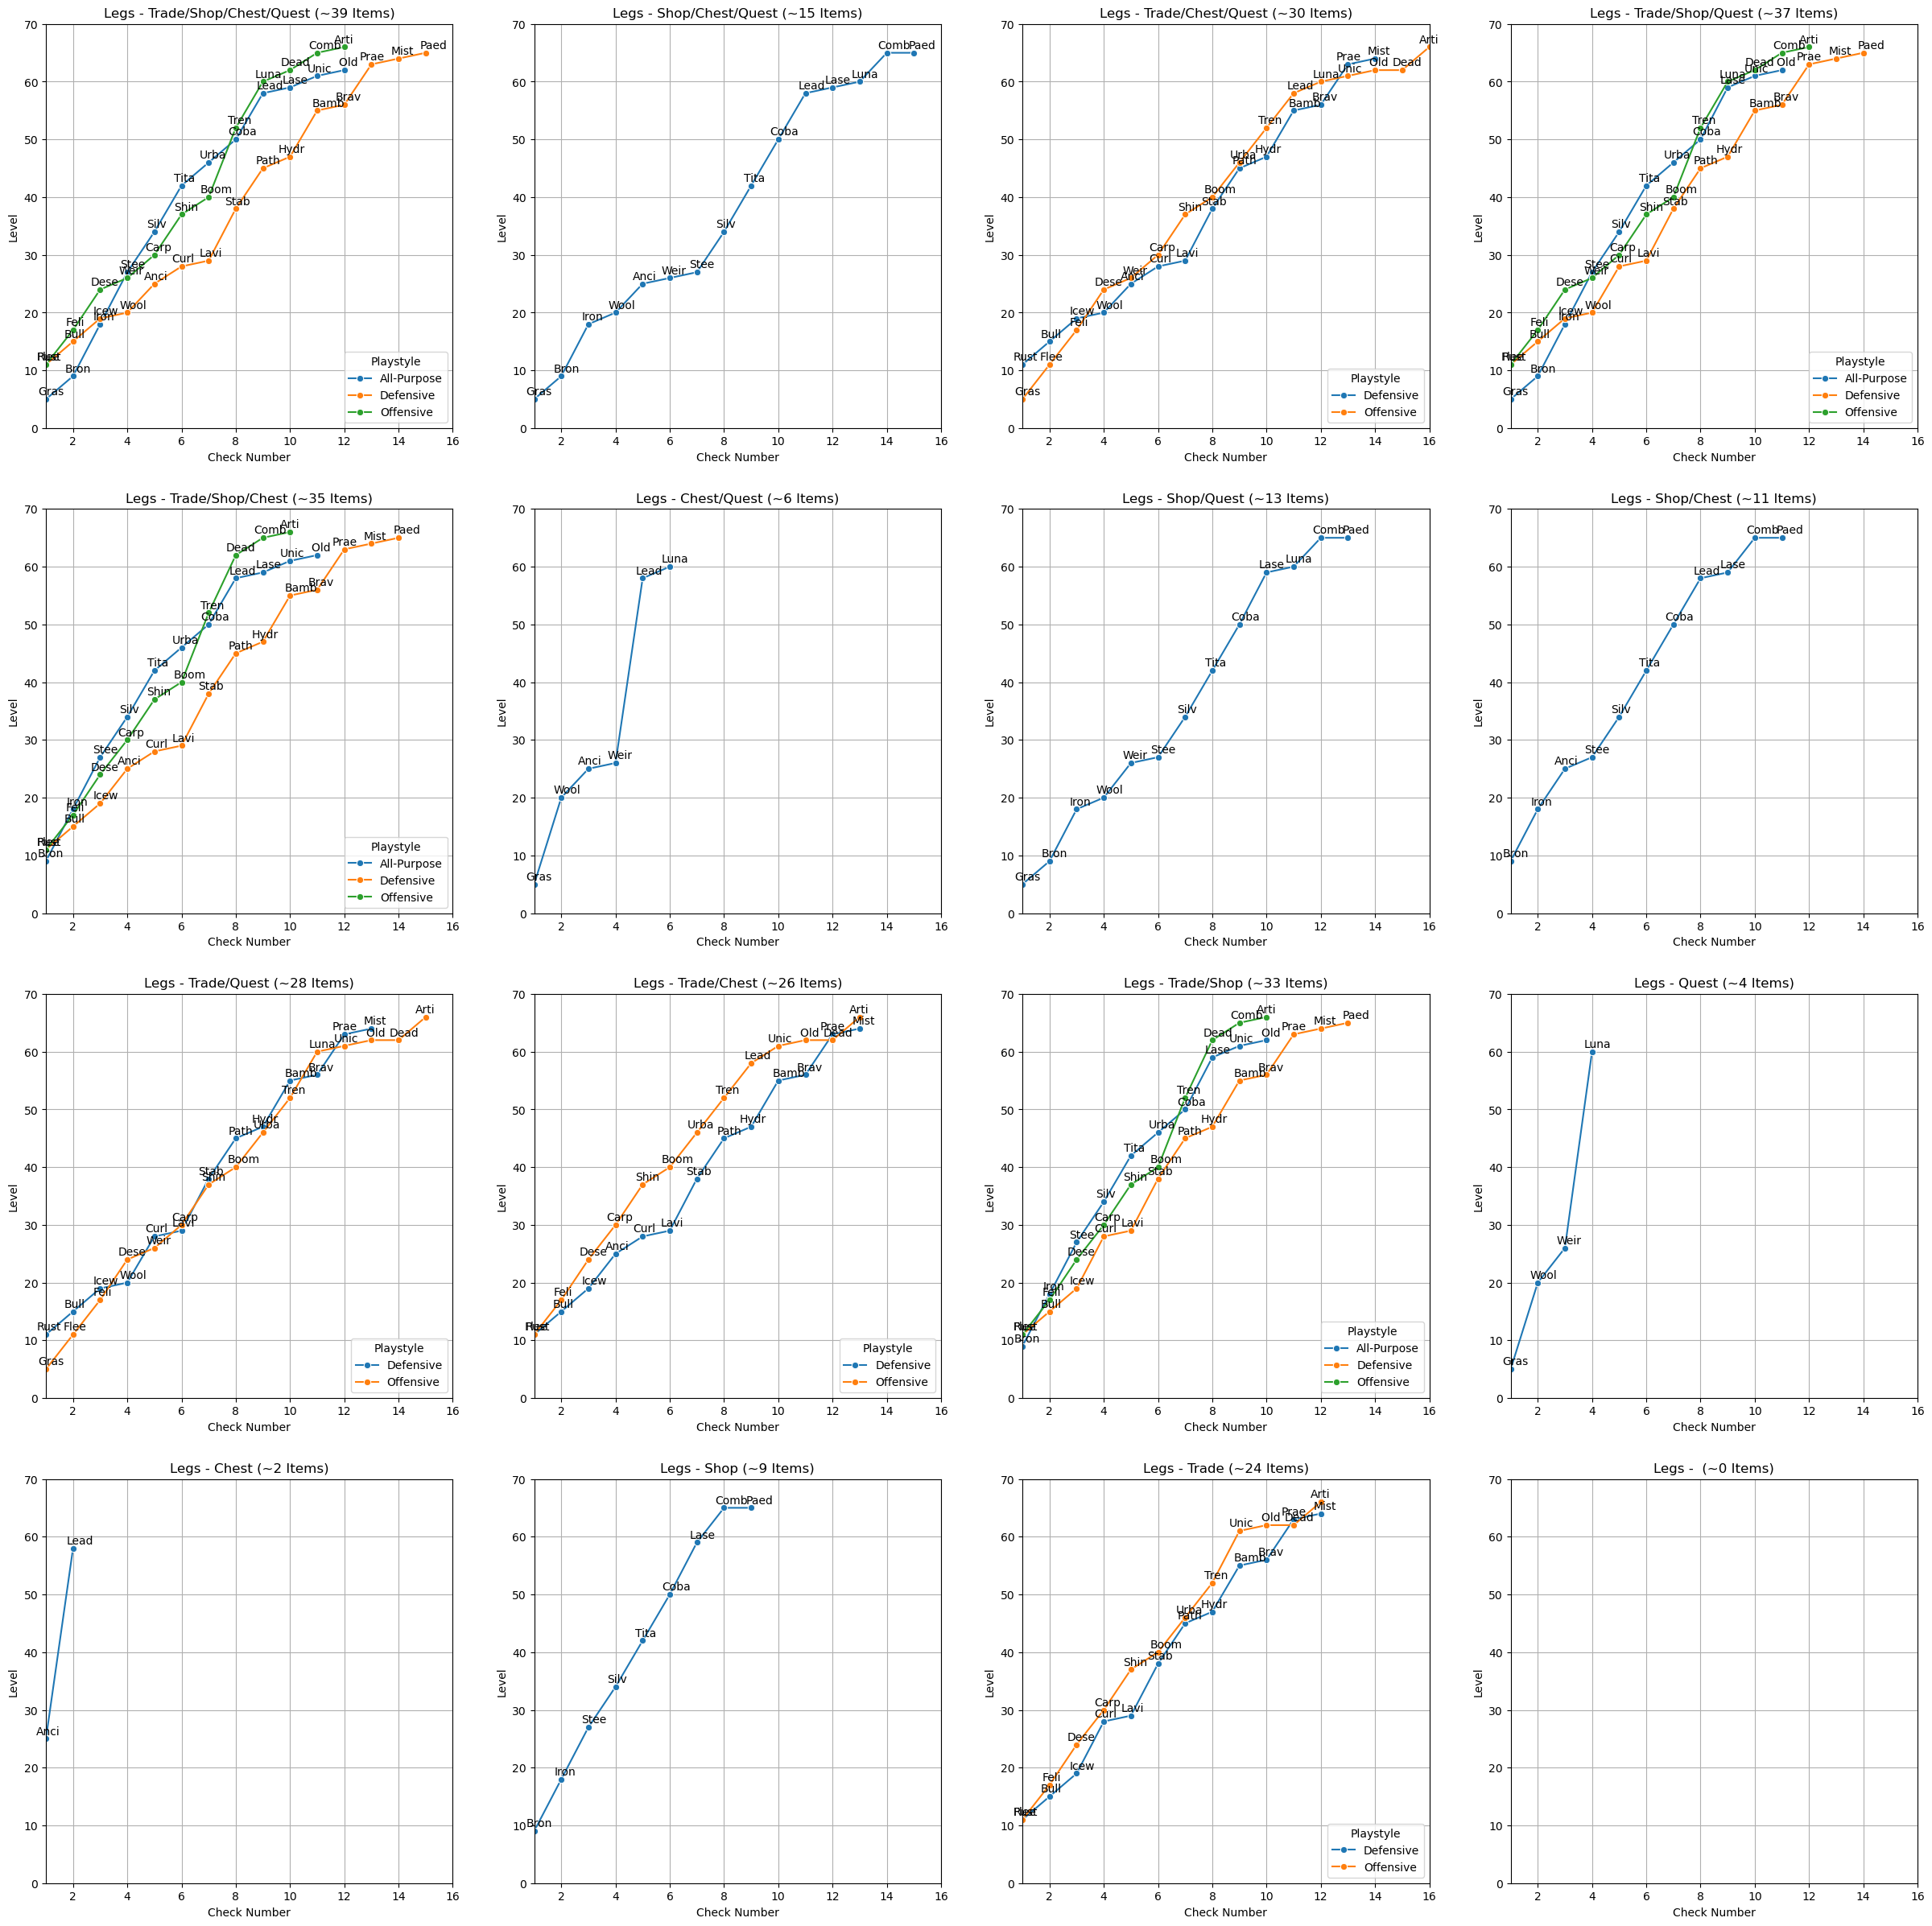

In [624]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import json
import re

# series_colors = {
#         'Any': '#888888',
#         'Offensive': '#D62728',
#         'Melee': '#D62728',
#         'Defensive': '#1F77B4',
#         'Ranged': '#FF6C08',
#         'Special': '#9467BD',
#         'Botany': '#2CA02C',
# }

# Adds text labels to each marker.
def label_point(x, y, val, ax):
        a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
        for i, point in a.iterrows():
                # Do some math to center each label approximately
                ax.text(
                        point['x'] - .025 * len(str(point['val'])),
                        point['y'] + 0.75,
                        str(point['val'][:4])
                )

def plot_graphs_and_write_json(df: pd.DataFrame, title: str, max_lim: int):
        plt.rcParams['axes.grid'] = True
        plt.rcParams['legend.loc'] = 'lower right'

        fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(30,30))
        plt.setp(ax, xlim=(1, max_lim), ylim=(0, 70))
        for a in ax.flatten():
                loc = plticker.MultipleLocator(base=2.0) # this locator puts ticks at regular intervals
                a.xaxis.set_major_locator(loc)

        # Reset JSON data
        json_filename = f'./Progressive{title}.json'
        json_data = {}
        open(json_filename, 'w').close()

        # Disable every combination of rando toggles and graph it
        v = 0
        w = 0
        for sub_combinations in obtained_combinations:
                for combo in sub_combinations:
                        # If the combo is a single string, make this an array with one string
                        if isinstance(combo, str): combo = [combo]
                        combo_inverted = list(filter(lambda x: x not in combo, OBTAINED_METHODS))
                        graph_data = pop_if_obtained_via(df, combo)

                        # If there is an additional obtained method, add +1 count, but only for arms
                        if (title == "Arms"):
                                for index, row in graph_data[~graph_data['Also Obtained Via'].isnull()].iterrows():
                                        graph_data.at[index, 'Base Count'] += 1

                        # Create manually defined graph adjustments
                        adjust_graph_data(graph_data, title, combo_inverted)
                        # print(graph_data)
                        graph_data = progressively_order(graph_data)

                        sns.lineplot(
                                x='Check Number', y='Level', marker='o', hue='Playstyle',
                                ax=ax[v][w],
                                data=graph_data).title.set_text('{0} - {1} (~{2})'.format(title, '/'.join(combo_inverted), str(len(graph_data.index)) + ' Items'))
                        label_point(graph_data['Check Number'], graph_data['Level'], graph_data['Name'], ax[v][w])

                        # Prepare JSON output
                        playstyle_list = get_playstyle_list(graph_data)
                        for playstyle in playstyle_list:
                                title_key = f'{playstyle} {title}'.lstrip().rstrip()
                                camel_case_title_key = camel_case(f'{title} {playstyle.capitalize()}'.lstrip().rstrip())

                                # Initialize series in data if it doesn't exist
                                if not camel_case_title_key in json_data:
                                        json_data[camel_case_title_key] = {
                                                'displayName': title_key,
                                                'id': get_id_from_series_id(camel_case_title_key),
                                                'classification': 'progression',
                                                'items': []
                                        }

                                # Include only `true` metadata
                                # json_metadata = { 'metadata': { str(c).lower(): True for c in combo_inverted } }

                                # Include `true` and `false` metadata
                                json_metadata = { 'metadata': { str(c).lower(): True for c in combo_inverted } | { str(c).lower(): False for c in combo } }
                                # Order the metadata
                                json_metadata = { 'metadata': {key: json_metadata['metadata'][key] for key in ["trade", "shop", "chest", "quest"] } }
                                json_content = { 'content': [] }
                                for item_name in graph_data[graph_data['Playstyle'] == playstyle]['Name']:
                                        item_count = int(graph_data[graph_data['Name'] == item_name]['Base Count'].values[0])
                                        json_content['content'].append({ 'item': ["item", item_name, item_count] })


                                json_data[camel_case_title_key]['items'].append(json_metadata | json_content)

                        # Cycle axis
                        w += 1
                        if w == 4:
                                v += 1
                                w = 0

        # Append global metadata
        json_data = {
                "_global": {
                        "progressiveChains": {
                                "*": {
                                        "multi": True
                                }
                        }
                },
                "progressiveChains": json_data
        }

        # Prettified data
        json_data_string = json.dumps(json_data, indent="\t")


        # Raw JSON formatter: makes all content arrays compact (very janky!)

        json_data_string_formatted = ""

        CONTENT_STRING = "\"content\": [\n"
        COMPACTIFY_NEWLINE_STRING = "} "

        find_content_string_count = 0
        find_newline_string_count = 0
        compactify_exit_scope_count = 0
        compactify_replace_newline_with_blank = False
        compactify = False

        # Iterate through every character
        for character in json_data_string:
                # Toggle compactify off if we're at the end of the section
                # Additionally, disable the extra whitespace around []
                if compactify:
                        if character == "[":
                                compactify_exit_scope_count += 1
                                compactify_replace_newline_with_blank = True
                        if character == "]":
                                compactify_exit_scope_count -= 1
                        if re.match(r"[0-9]+", character): compactify_replace_newline_with_blank = True
                        if compactify_exit_scope_count == -1:
                                compactify_exit_scope_count = 0
                                compactify = False

                # Do not compact anything here
                if not compactify:
                        # If the string is found, then toggle compact formatting
                        if character == CONTENT_STRING[find_content_string_count]:
                                find_content_string_count += 1
                                if find_content_string_count == len(CONTENT_STRING) - 1:
                                        # print(f"compact found -{CONTENT_STRING[find_content_string_count-1]}{CONTENT_STRING[find_content_string_count]}-")
                                        compactify = True
                        # Otherwise, just reset the count again
                        else: find_content_string_count = 0

                # Compact everything here
                if compactify:
                        if character == "{": character = "\n\t\t\t\t\t\t{"
                        # Disables extra " " whitespace temporarily
                        if character == "\n":
                                if compactify_replace_newline_with_blank:
                                        character = ""
                                        compactify_replace_newline_with_blank = False
                                else: character = " "
                        if character == "\t": character = ""

                        # Format closing brace
                        if character == COMPACTIFY_NEWLINE_STRING[find_newline_string_count]:
                                find_newline_string_count += 1
                                if find_newline_string_count == len(COMPACTIFY_NEWLINE_STRING):
                                        character += "\n\t\t\t\t\t"
                                        find_newline_string_count = 0
                        else: find_newline_string_count = 0

                json_data_string_formatted += str(character)

        # Append newline
        json_data_string_formatted += "\n"

        # Write to JSON
        with open(json_filename, 'w') as f:
                f.write(json_data_string_formatted)

plot_graphs_and_write_json(arms_data, 'Arms', 16)
plot_graphs_and_write_json(heads_data, 'Heads', 16)
plot_graphs_and_write_json(torsos_data, 'Torsos', 20)
plot_graphs_and_write_json(legs_data, 'Legs', 16)